## Índice:
* [1 - Introdução](#first-bullet)
* [2 - EDA](#second-bullet)
* [3 - Estratégia de validação e treino do modelo](#third-bullet)

> referencia: https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook

## 1 - Introdução <a class="anchor" id="first-bullet"></a>

O objetivo desse jupyter notebook é cumprir com o requisto vivencial da Trilha de Cientista de Dados da Petrobras.

O caso de estudo escolhido foi: Santander Customer Transaction. Abaixo segue a tradução para o português do desafio proposto pelo Santander.

Neste desafio, nós convidamos os Kagglers para nos ajudar a identificar quais clientes irão fazer uma transação especifica no futuro, independente da quantia de dinheiro envolvido. Os dados providos para essa competição tem a mesma estrutura do real que temos para resolver esse problema.

## 2 - EDA <a class="anchor" id="second-bullet"></a>

> https://www.kaggle.com/code/gpreda/santander-eda-and-prediction

De acordo com a própria descrição do problema trata-se de dados fakes criados especificamente para esse desafio com as mesmas caracteritiscas dos dados reais.

### Importando os módulos necessários e os datasets oferecidos pelo desafio

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import gc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_df= pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
sample_submission = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')

### Avaliando os dados

In [ ]:
train_df.shape, test_df.shape

Os datasets de treinamento e teste possuem 200.000 amostras, 202 e 201 colunas, respectivamente.

In [ ]:
train_df.head()

In [ ]:
test_df.head()

### Tipo dos dados

In [ ]:
train_df.info(), test_df.info()

*** Dados de treino**

    200 features numéricas (var_0 até var_199), 1 feature string (ID_code), 1 variavel de saida (target)
    
*** Dados de teste**

    200 features numéricas (var_0 até var_199), 1 feature string (ID_code)

### Análise se as features são discretas ou contínuas

Com intuito de verificar se as features são discretas ou contínuas será verficado a quantidade de valores únicos por feature. Caso esse valor seja superior a 20, trata-se de uma variável continua. Caso contrário, discreta.

In [ ]:
feats = [f for f in train_df.columns if f not in ['ID_code','target']]
unique_df = pd.DataFrame(columns=['continua','discreta'],index=feats)

for feat in feats:
    num_unique = len(train_df[feat].unique())
    if(num_unique>=20):
        unique_df.loc[feat,"contínua"] = 1
    else:
        unique_df.loc[feat,"discreta"] = 1

num_continuous_var = unique_df["contínua"].sum()
num_continuous_var

Todas as 200 features são contínuas.

### Avaliando missing values

In [ ]:
null_df = train_df.isnull().sum()
null_df = null_df[null_df > 0]
null_df

In [ ]:
null_df = test_df.isnull().sum()
null_df = null_df[null_df > 0]
null_df

Não existe valores faltantes nos datasets de treino e teste.

### Análise estatística das features

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

O dataset de teste possui os valores de média e desvio padrão para cada feature muito próximos do dataset de treino

Para avaliar se o desvio padrão está condizente usaremos o coeficiente de variação, definido por: cv = std / mean

https://www.statology.org/coefficient-of-variation-in-python/

### Normalizando os dados

In [ ]:
scaler = StandardScaler()
train_df_scale = train_df.copy()
train_df_scale[feats] = scaler.fit_transform(train_df[feats])

train_df_scale.head()

### Distribuição dos valores da variável target

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train_df.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=train_df.target.values, y=train_df.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=train_df.target.values, y=train_df.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index");
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");

Os dados da variavel target estão desabalanceados, existem muito mais casos com valor 0, do que com valor 1. 

### Avaliando a Matriz de Confusão c/ dados de treino - Baseline

In [ ]:
target_ratio = 100* train_df['target'].sum() / len(train_df['target'])
target_ratio

In [ ]:
def plot_confusion_matrix(cf_matrix):
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

model = LGBMClassifier()

y_pred = cross_val_predict(model, train_df[feats], train_df['target'], cv=5)


cf_matrix = confusion_matrix(train_df['target'], y_pred)
# plot confusion matrix
plot_confusion_matrix(cf_matrix)

### Avaliando a Matriz de Confusão c/ dados de treino - Balanceados

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy=0.15)
#undersample = RandomUnderSampler(sampling_strategy=0.15)
X_over, y_over = oversample.fit_resample(train_df_scale[feats], train_df_scale['target'])

In [ ]:
target_ratio = 100* y_over.sum()/len(y_over)
target_ratio

In [ ]:
model = LGBMClassifier()

y_pred = cross_val_predict(model, X_over, y_over, cv=5)


cf_matrix = confusion_matrix(y_over, y_pred)
# plot confusion matrix
plot_confusion_matrix(cf_matrix)

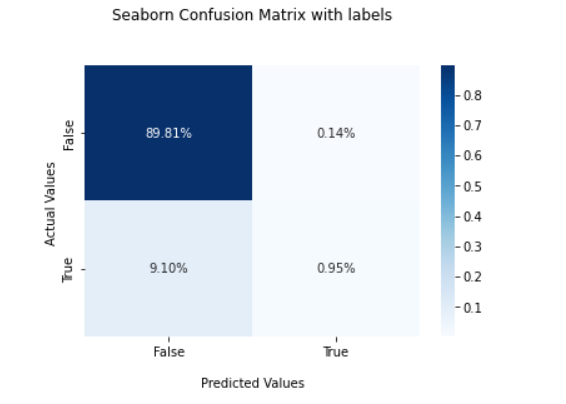

BASELINE ACCURACY 90.76%

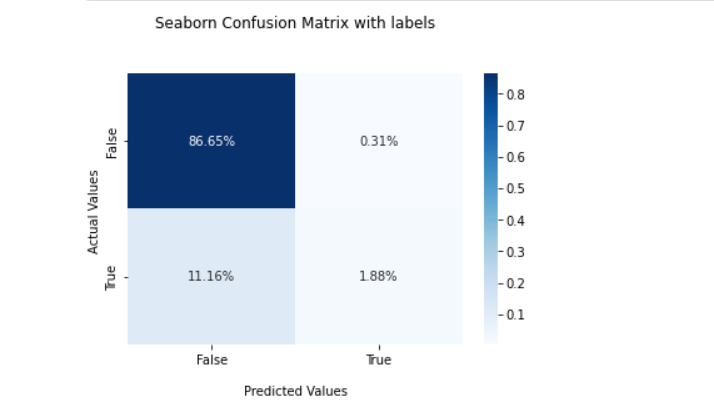

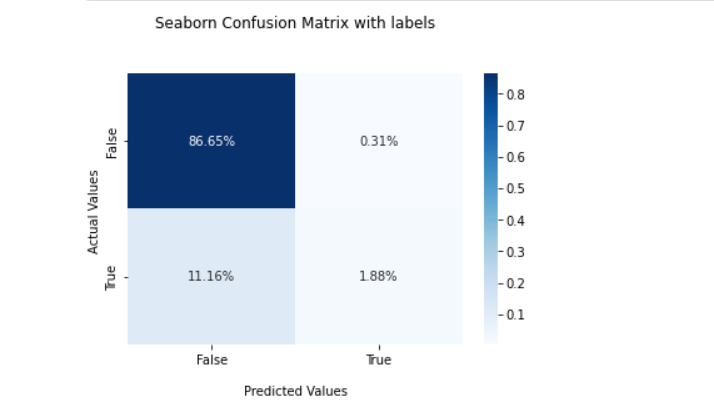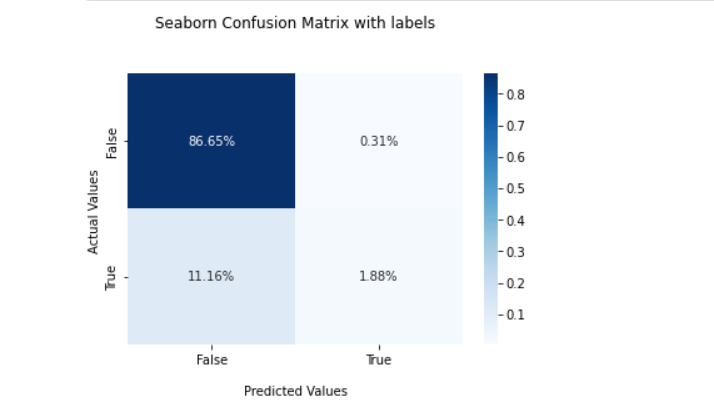

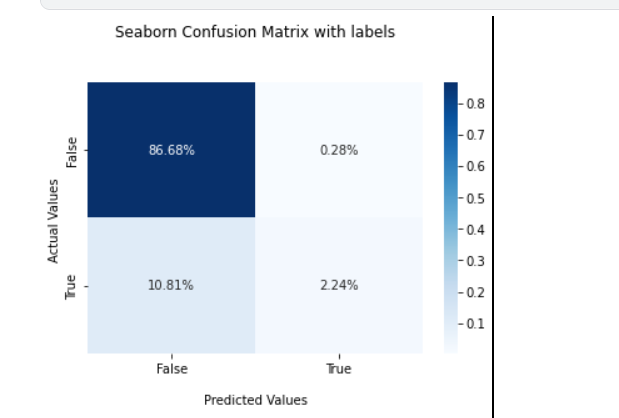

OVERSAMPLING 0.15 ACCURACY 88.92%

### Criando novos dados da minoria usando SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter


oversample = SMOTE(sampling_strategy=0.15)
under = RandomUnderSampler(sampling_strategy=0.5)

X_smote, y_smote = oversample.fit_resample(train_df_scale[feats], train_df_scale['target'])

X_smote, y_smote = under.fit_resample(X_smote, y_smote)

counter = Counter(y_smote)
print(counter)

In [ ]:
model = LGBMClassifier()

y_pred = cross_val_predict(model, X_smote, y_smote, cv=5)


cf_matrix = confusion_matrix(y_smote, y_pred)
# plot confusion matrix

plot_confusion_matrix(cf_matrix)

### Balancenado os dados de treino

In [ ]:
!sudo pip install imbalanced-learn

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_df[feats], train_df['target'])

In [ ]:
y_over

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(y_over.values, ax=ax[0], palette="husl")

ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");

### Avaliando feature importance a partir de um modelo lightcorrelação das features com a variavel target

In [ ]:
model = LGBMClassifier()

# fit the model
model.fit(X_over, y_over)
# get importance
importance = model.feature_importances_
# summarize feature importance
importance_dict={}
for i,v in enumerate(importance):
    importance_dict['var_'+str(i)] = v
    
sort_importance_dict_over = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}
sort_importance_dict_over

In [ ]:
model = LGBMClassifier()

# fit the model
model.fit(train_df[feats], train_df['target'])
# get importance
importance = model.feature_importances_
# summarize feature importance
importance_dict={}
for i,v in enumerate(importance):
    importance_dict['var_'+str(i)] = v
    
sort_importance_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}
sort_importance_dict

Visando utilizar no treinamento do modelo as features com maior importancia, serão descartadas as features importance com valor 0.

In [ ]:
# new_feats_dict = {k: v for k, v in sort_importance_dict.items() if v> 0}
# new_feats = list(new_feats_dict.keys())

new_feats_dict_over = {k: v for k, v in sort_importance_dict_over.items() if v> 0}
new_feats_over = list(new_feats_dict_over.keys())

Os valores obtidos para a correlação entre as features e a variavel target são bem baixos, indicando que não existe uma correlação de Pearson entre estes.

### Distribuição dos dados classificados para as 10 features com maior importância

> https://www.kaggle.com/code/allunia/santander-customer-transaction-eda

In [ ]:
n_top = 10
feature_names = new_feats[:n_top]
fig, ax = plt.subplots(n_top,2,figsize=(20,5*n_top))

for n in range(n_top):
    sns.distplot(train_df.loc[train_df.target==0, feature_names[n]], ax=ax[n,0], color="Orange", norm_hist=True)
    sns.distplot(train_df.loc[train_df.target==1, feature_names[n]], ax=ax[n,0], color="Red", norm_hist=True)
    sns.distplot(test_df.loc[:, feature_names[n]], ax=ax[n,1], color="Mediumseagreen", norm_hist=True)
    ax[n,0].set_title("Train {}".format(feature_names[n]))
    ax[n,1].set_title("Test {}".format(feature_names[n]))
    ax[n,0].set_xlabel("")
    ax[n,1].set_xlabel("")

## 3 - Estratégia de validação e treino do modelo <a class="anchor" id="third-bullet"></a>

### Análise inicial para comparação dos modelos com parametros default (Usando train_test_split)

Nesta fase do trabalho será realizado um treinamento do modelo utilizando vários algoritmos diferentes de classificação binária presentes no módulo scikit-learn. O critério de escolha do modelo será feito pelo melhor score F2. 

Serão considerados como dados de treinos três casos com 10 features, 100 features e 200 features escolhidos a partir do critério de maior coeficiente de correlação linear, conforme mostrado na seção interior. 

O script foi baseado em: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
results_df = pd.DataFrame()

In [ ]:
names = [
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "LightGBM"
]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    LGBMClassifier()
]

results_df['Algoritmos'] = names
results_df.set_index('Algoritmos', inplace=True)

feature_names = new_feats

# preprocess dataset, split into training and test part
train_x, valid_x, train_y, valid_y = train_test_split(train_df[feature_names], train_df['target'], test_size=0.4, random_state=42)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(train_x, train_y)
    score = clf.score(valid_x, valid_y)
    results_df.loc[name, len(new_feats)] = score
    print("Algoritmo:",name,"F2 score:",score, "Numero de features:", len(new_feats))


In [ ]:
results_df.style.highlight_max(color = 'yellow')

In [ ]:
names = [
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "LightGBM"
]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    LGBMClassifier()
]

results_df['Algoritmos'] = names
results_df.set_index('Algoritmos', inplace=True)

feature_names = new_feats_over

# preprocess dataset, split into training and test part
train_x, valid_x, train_y, valid_y = train_test_split(X_over, y_over, test_size=0.4, random_state=42)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(train_x, train_y)
    score = clf.score(valid_x, valid_y)
    results_df.loc[name, len(new_feats)] = score
    print("Algoritmo:",name,"F2 score:",score, "Numero de features:", len(new_feats))

### Testando lightGBM parametros default 100 features

In [ ]:
names = [
    "LightGBM"
]

classifiers = [
    LGBMClassifier()
]

i=len(new_feats_over)
feature_names = new_feats_over

# preprocess dataset, split into training and test part
train_x, valid_x, train_y, valid_y = train_test_split(X_over, y_over, test_size=0.4, random_state=42)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(train_x, train_y)
    pred = clf.predict_proba(test_df[feature_names])[:, 1]
    score = clf.score(valid_x, valid_y)
    results_df.loc[name, i] = score
    print("Algoritmo:",name,"F2 score:",score, "Numero de features:", i)

sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = pred
sub_df.to_csv("submission_GBM_default_over.csv", index=False)

In [ ]:
names = [
    "LightGBM"
]

classifiers = [
    LGBMClassifier()
]

i=len(new_feats)
feature_names = new_feats

# preprocess dataset, split into training and test part
train_x, valid_x, train_y, valid_y = train_test_split(train_df[feature_names], train_df['target'], test_size=0.4, random_state=42)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(train_x, train_y)
    pred = clf.predict_proba(test_df[feature_names])[:, 1]
    score = clf.score(valid_x, valid_y)
    results_df.loc[name, i] = score
    print("Algoritmo:",name,"F2 score:",score, "Numero de features:", i)

sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = pred
sub_df.to_csv("submission_GBM_default.csv", index=False)

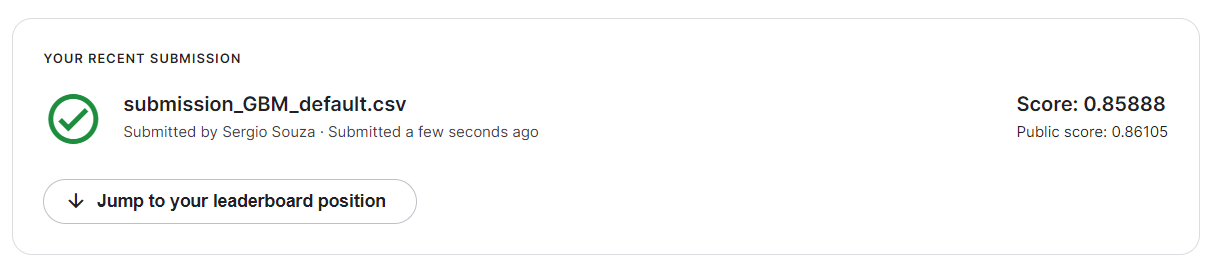

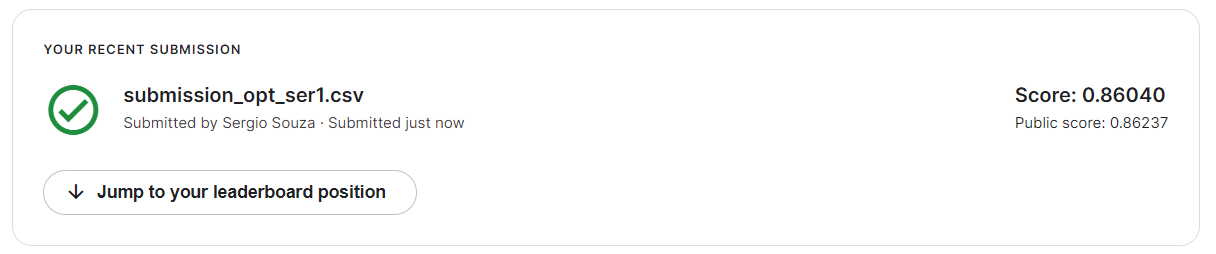

MANTER ESSE!!!

Os resultados acima foram obtidos considerando a divisão dos dados de treino e teste usando train_test_split. Ao submeter os resultados obtive um score 0.86 aproximadadamente o que indica que o modelo está com overfitting, já que o score somente com dado de treinamento 0.91.

### Utilizando kfold para validação cruzada c/ parametro default

> https://www.kaggle.com/code/ashishpatel26/kfold-lightgbm/notebook

Para diminuir o overfitting a primeira alternativa foi utilizar o método kfold para divisão dos dados de treino/validação. Usei 10 folds estratificados. 

In [ ]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [ ]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['ID_code','target']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            )
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 3000)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['target'] = sub_preds
        test_df[['ID_code','target']].to_csv('submission_cv_strat_opt.csv', index= False)
        print('csv impresso')
    return feature_importance_df

In [ ]:

feature_names = new_feats[:]
feature_names.append('ID_code')
feature_names_target = feature_names[:]
feature_names_target.append('target')
df = train_df[feature_names_target].append(test_df[feature_names])
#feature_importance_df = kfold_lightgbm(df, num_folds= 10, stratified = True, debug= False)

In [ ]:
train_df_over=X_over.copy()

In [ ]:
train_df_over['target']=y_over

In [ ]:
train_df_over.tail()

In [ ]:
feature_names = new_feats_over[:]
#feature_names.append('ID_code')
feature_names_target = feature_names[:]
feature_names_target.append('target')
train_df_over['ID_code']=''
df = train_df_over[feature_names_target].append(test_df[feature_names])
#feature_importance_df = kfold_lightgbm(df, num_folds= 10, stratified = True, debug= False)

In [ ]:
import lightgbm as lgb
def kfold_lightgbm_optimized(df, num_folds, params_opt, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['target']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        trn_data = lgb.Dataset(train_x, train_y)
        val_data = lgb.Dataset(valid_x, valid_y)

        num_round = 1000000
        
        ##clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 3000)
    
        clf = lgb.train(params_opt, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration) / folds.n_splits   
        
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['target'] = sub_preds
        test_df[['ID_code','target']].to_csv('submission_opt_ser1.csv', index= False)
        print('csv impresso')
    #display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
param = {'nthread': 8,
 'n_estimators': 15000,
'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'num_leaves': 15, 'max_depth':4, 'verbosity':-1}

In [ ]:
kfold_lightgbm_optimized(df, 10, param, stratified = True, debug= False)

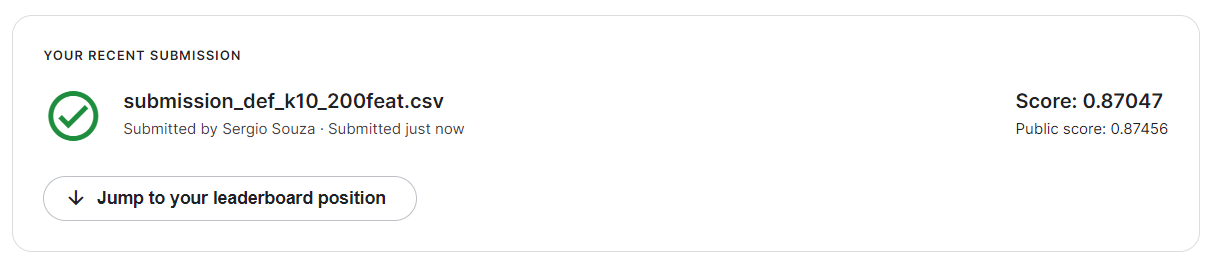

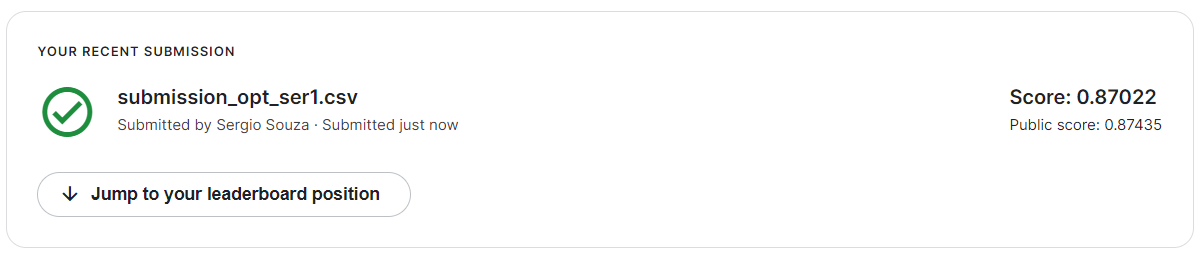

MANTER ESSE!!

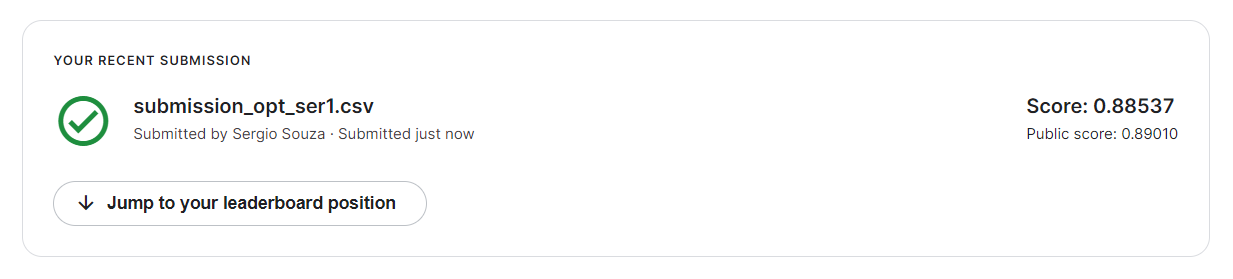

USANDO PARAM = {}

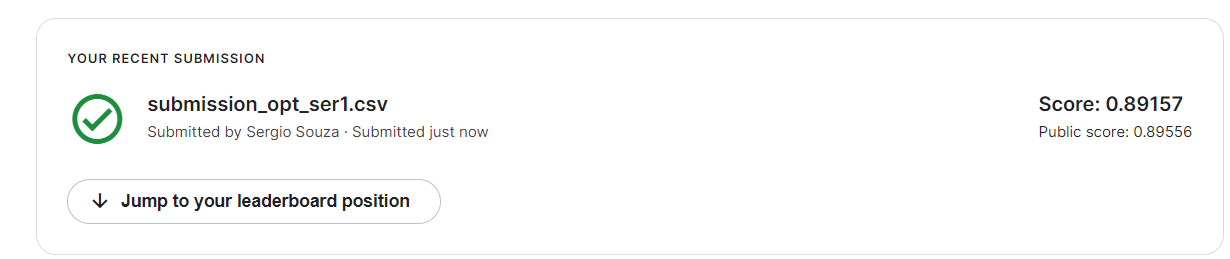

USANDO PARAM = {'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': 15,
        'max_depth':4}

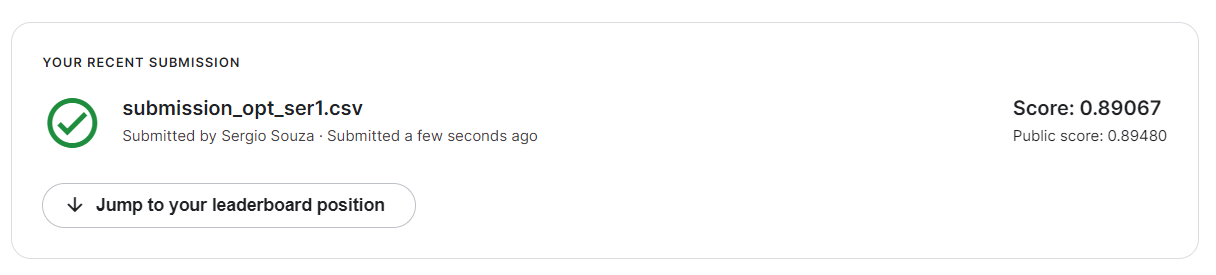

USANDO PARAM = {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth':5}

Após utilizar o método kfold com 10 pastas para fazer a validação cruzada entre os dados de treino e de teste o score subiu p/ 0.87, indicando que o modelo está generalizando bem melhor.

### Análise somente com max_depth e num' laves

In [ ]:
def kfold_lightgbm_optimized(df, num_folds, params_opt, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    feats = [f for f in train_df.columns if f not in ['ID_code','target']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        trn_data = lgb.Dataset(train_x, train_y)
        val_data = lgb.Dataset(valid_x, valid_y)

        num_round = 1000000

        clf = lgb.train(params_opt, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration) / folds.n_splits   

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['target'] = sub_preds
        test_df[['ID_code','target']].to_csv('submission_opt_ser1.csv', index= False)
        print('csv impresso')
    #display_importances(feature_importance_df)
    return None

In [ ]:
kfold_lightgbm_optimized(df, 10, {}, stratified = True, debug= False)

In [ ]:
param={'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth':5}

In [ ]:
kfold_lightgbm_optimized(df, 10, param, stratified = True, debug= False)

### Otimizando os hyper-parametros do lightGBM

> https://towardsdatascience.com/seeing-numbers-bayesian-optimisation-of-a-lightgbm-model-3642228127b3

> https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5#:~:text=In%20LGBM%2C%20the%20most%20important,the%20%27actual%20decision%27%20happens.

In [ ]:
import lightgbm as lgb

feature_names = new_feats
#feature_names.append('ID_code')
feature_names_target = feature_names[:]
feature_names_target.append('target')
# df = train_df[feature_names_target].append(test_df[feature_names])

dtrain = lgb.Dataset(data=train_df[feature_names], label=train_df['target'])

Parametros mais relevantes p otmização de acordo com as referências citadas acima são: num_leaves, max_depth e learning_rate. O learning_rate foi fixado em 0.01. No caso do num_leaves foi usada a relação 2^num_leaves - 1 = max_depth.

Foram feitas várias simulações com diferentes configurações de num_leaves e max_depth, o melhor resultado de score foi obtido com num_leaves=15 e max_depth=4

Visando diminir ainda mais o overfitting e aumentar o score foi feita uma otimização de parametros através do método otimização bayesiana. De acordo as refs acima os parametros que mais ajudam a diminuir o overfitting são: bagging_fraction, bagging_frequency e feature fraction



In [ ]:
import lightgbm as lgb

feature_names = new_feats_over
#feature_names.append('ID_code')
feature_names_target = feature_names[:]
feature_names_target.append('target')
# df = train_df[feature_names_target].append(test_df[feature_names])

train_df_over = X_over.copy()
train_df_over['target'] = y_over
train_df_over['ID_code'] = ''

dtrain = lgb.Dataset(data=train_df_over[feature_names], label=train_df_over['target'])

In [ ]:
def cross_val(num_leaves, min_data_in_leaf, max_depth):

    #(num_leaves=8,bag_frac=0.8,bag_freq=5, max_depth=-1):
    '''
    A function to return cross-validated LightGBM model accuracy
    
    Inputs
      eta: float, learning rate for model
      num_leaves: int, maximum number of leaves in tree
      bag_freq: int, frequency of bagging
      feat_frac: float, feature fraction
    
    Outputs
      float, model accuracy from best iteration of cross-validated model
    '''

    # set the model parameters
    parameters = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf':int(min_data_in_leaf),
        'max_depth':int(max_depth),
        'verbosity': -1,
        'feature_pre_filter': False
    }

    model = lgb.cv(
        params=parameters,
        train_set=dtrain,
        num_boost_round=500,
        nfold=10,
        stratified=True,
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    # return accuracy rather than error
    # as the optimiser seeks to maximise rather than minimise
    return model['auc-mean'][-1]

In [ ]:
def cross_val(bagg_frac, bagg_freq, feat_frac):

    #(num_leaves=8,bag_frac=0.8,bag_freq=5, max_depth=-1):
    '''
    A function to return cross-validated LightGBM model accuracy
    
    Inputs
      eta: float, learning rate for model
      num_leaves: int, maximum number of leaves in tree
      bag_freq: int, frequency of bagging
      feat_frac: float, feature fraction
    
    Outputs
      float, model accuracy from best iteration of cross-validated model
    '''

    # set the model parameters
    parameters = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': 15,
        'max_depth':4,
        'bagging_freq': int(bagg_freq),
        'bagging_fraction': bagg_frac,
        'feature_fraction': feat_frac,
        'verbosity': -1,
        'feature_pre_filter'=False
    }

    model = lgb.cv(
        params=parameters,
        train_set=dtrain,
        num_boost_round=500,
        nfold=10,
        stratified=True,
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    # return accuracy rather than error
    # as the optimiser seeks to maximise rather than minimise
    return model['auc-mean'][-1]

In [ ]:
from bayes_opt import BayesianOptimization

from hyperopt import hp

# space = {
#     'bagg_frac': (0.4,0.8),
#     'bagg_freq':(1,5),
#     'feat_frac':(0.01,0.1)
# }

space = {
    "num_leaves": (4, 200),
    "min_data_in_leaf":(200, 2000),
    "max_depth":(2,10)
}


# set up the optimiser
optimiser = BayesianOptimization(
    f=cross_val,
    pbounds=space,
    verbose=2,
    random_state=0)

# Optimize
optimiser.maximize(init_points=5, n_iter=50)


In [ ]:
params_opt = optimiser.max['params']

In [ ]:
params_opt

In [ ]:
params ={  'nthread':8,
            'n_estimators':15000,
            'learning_rate':0.01,
            'num_leaves':15,
            'max_depth':4,
            'objective':'binary',
            'metric':'auc',
            'verbose':-1}

In [ ]:
params['bagging_freq'] = round(params_opt['bagg_freq'])
params['bagging_fraction'] = params_opt['bagg_frac']
params['feature_fraction'] = params_opt['feat_frac']

In [ ]:
params

### Testando o modelo com os parametros otimos

In [ ]:
del df
n_top = 200
feature_names = new_feats[:]
feature_names.append('ID_code')
feature_names_target = feature_names[:]
feature_names_target.append('target')
df = train_df[feature_names_target].append(test_df[feature_names])

In [ ]:
def kfold_lightgbm_optimized(df, num_folds, params_opt, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['ID_code','target']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        trn_data = lgb.Dataset(train_x, train_y)
        val_data = lgb.Dataset(valid_x, valid_y)

        num_round = 1000000
        
        ##clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 3000)
    
        clf = lgb.train(params_opt, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration) / folds.n_splits   
        
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['target'] = sub_preds
        test_df[['ID_code','target']].to_csv('submission_opt_ser1.csv', index= False)
        print('csv impresso')
    #display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
feature_importance_df = kfold_lightgbm_optimized(df, 10, params, stratified = True, debug= False)

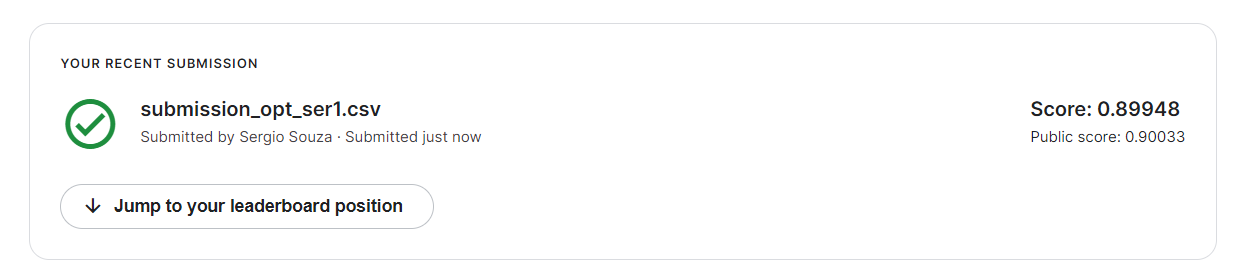

Após a otimização dos parametros o valor do score privado ficou com 0.89948.

In [ ]:
params = {'nthread': 8,
 'n_estimators': 15000,
 'learning_rate': 0.01,
 'num_leaves': 15,
 'max_depth': 4,
 'objective': 'binary',
 'min_data_in_leaf': 200,
 'min_sum_hessian_in_leaf': 10,
 'metric': 'auc',
 'verbose': -1,
 'bagging_freq': 2,
 'bagging_fraction': 0.46924977496735165,
 'feature_fraction': 0.01570058515228036,
 'lambda_l1':0.02}

feature_importance_df = kfold_lightgbm_optimized(df, 10, params, stratified = True, debug= False)


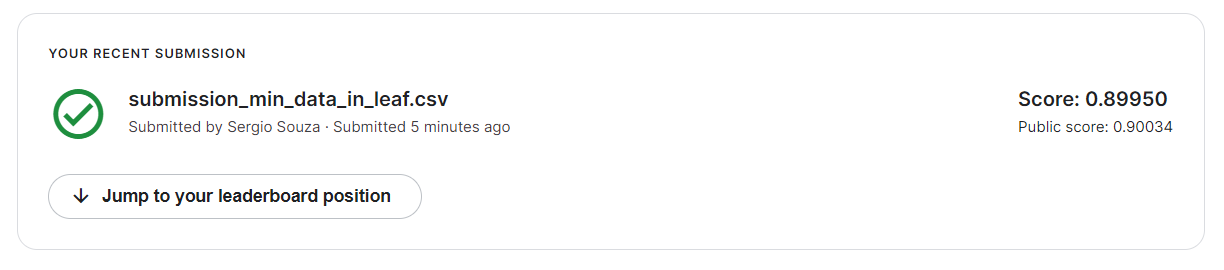

Inclui novos parametros que ajudam a diminuir o overfitting do modelo:  min_data_in_leaf, min_sum_hessian_in_leaf, lambda_l1. Porém o socre aumentou muito pouco.